In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from ewtpy import EWT1D
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

In [2]:
def get_mat_voltage(filepath, plot=False):
    """
    sampling rate: 10Hz
    """
    f = loadmat(filepath)

    # current = f['I_full_vec_M1_NMC25degC']
    # time = f['t_full_vec_M1_NMC25degC']
    voltage = f['V_full_vec_M1_NMC25degC']
    step = f['Step_Index_full_vec_M1_NMC25degC']
    if plot:
        plt.plot(step, c='black', label='step')
        plt.plot(voltage, c='blue', label='voltage')
        plt.xlabel('time(s)')
        plt.legend()
        plt.show()
        plt.close()
    return voltage, step

In [3]:
dc_v = []
for i in range(4):
    v, s = get_mat_voltage(filepath="Stanford_Dataset/Cycling_%d/W8.mat"%(i+1))
    v[s!=14] = 0 # remove non-discharging part
    dif = np.abs(np.diff(v, axis=0)) # calculate discharge boundaries
    edge = np.argwhere(dif>1)+1 # find discharge boundaries
    dc_v+=[v[edge[i, 0]:edge[i+1, 0]] for i in range(0, len(edge)-1, 2)] # separate discharge area, len(edge)-1 for odd number boundaries
    print('partial discharge segments=%d'%(len(edge)//2))
print('total discharge segments=%d'%len(dc_v))

partial discharge segments=24
partial discharge segments=49
partial discharge segments=49
partial discharge segments=23
total discharge segments=145


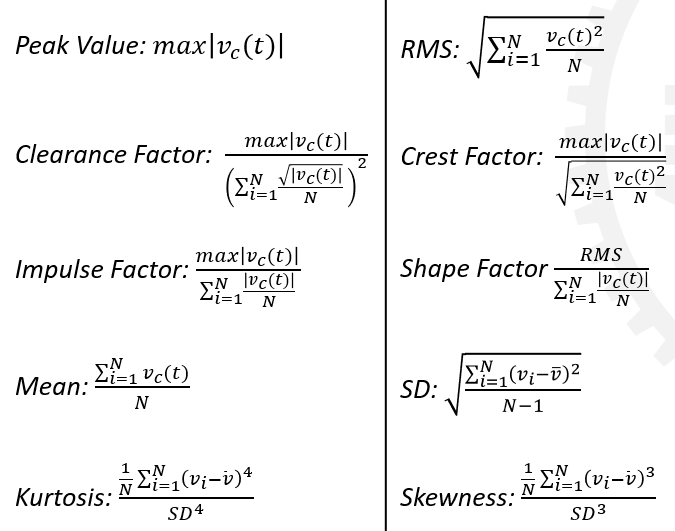

In [4]:
def feature_extraction(v):
    v_abs = np.abs(v)

    v_peak = np.max(v_abs) # peak value
    sd = np.std(v) # standard deviation
    m = np.mean(v) # mean
    kur = np.mean((v-m)**4)/sd**4 # kurtosis  
    skew = np.mean((v-m)**3)/sd**3 # skewness
    rms = np.sqrt(np.mean(v**2)) # RMS
    snr =  m/sd # SNR
    cl_f = v_peak/((np.mean(np.sqrt(v_abs)))**2) # clearance factor
    cr_f = v_peak/np.sqrt(np.mean(v**2)) # crest factor
    ip_f = v_peak/np.mean(v_abs) # impulse factor   
    sh_f = rms/np.mean(v_abs) # shape factor
    return [cl_f, cr_f, ip_f, kur, m, v_peak, rms, sh_f, skew, sd]

100%|██████████| 145/145 [17:23<00:00,  7.20s/it]


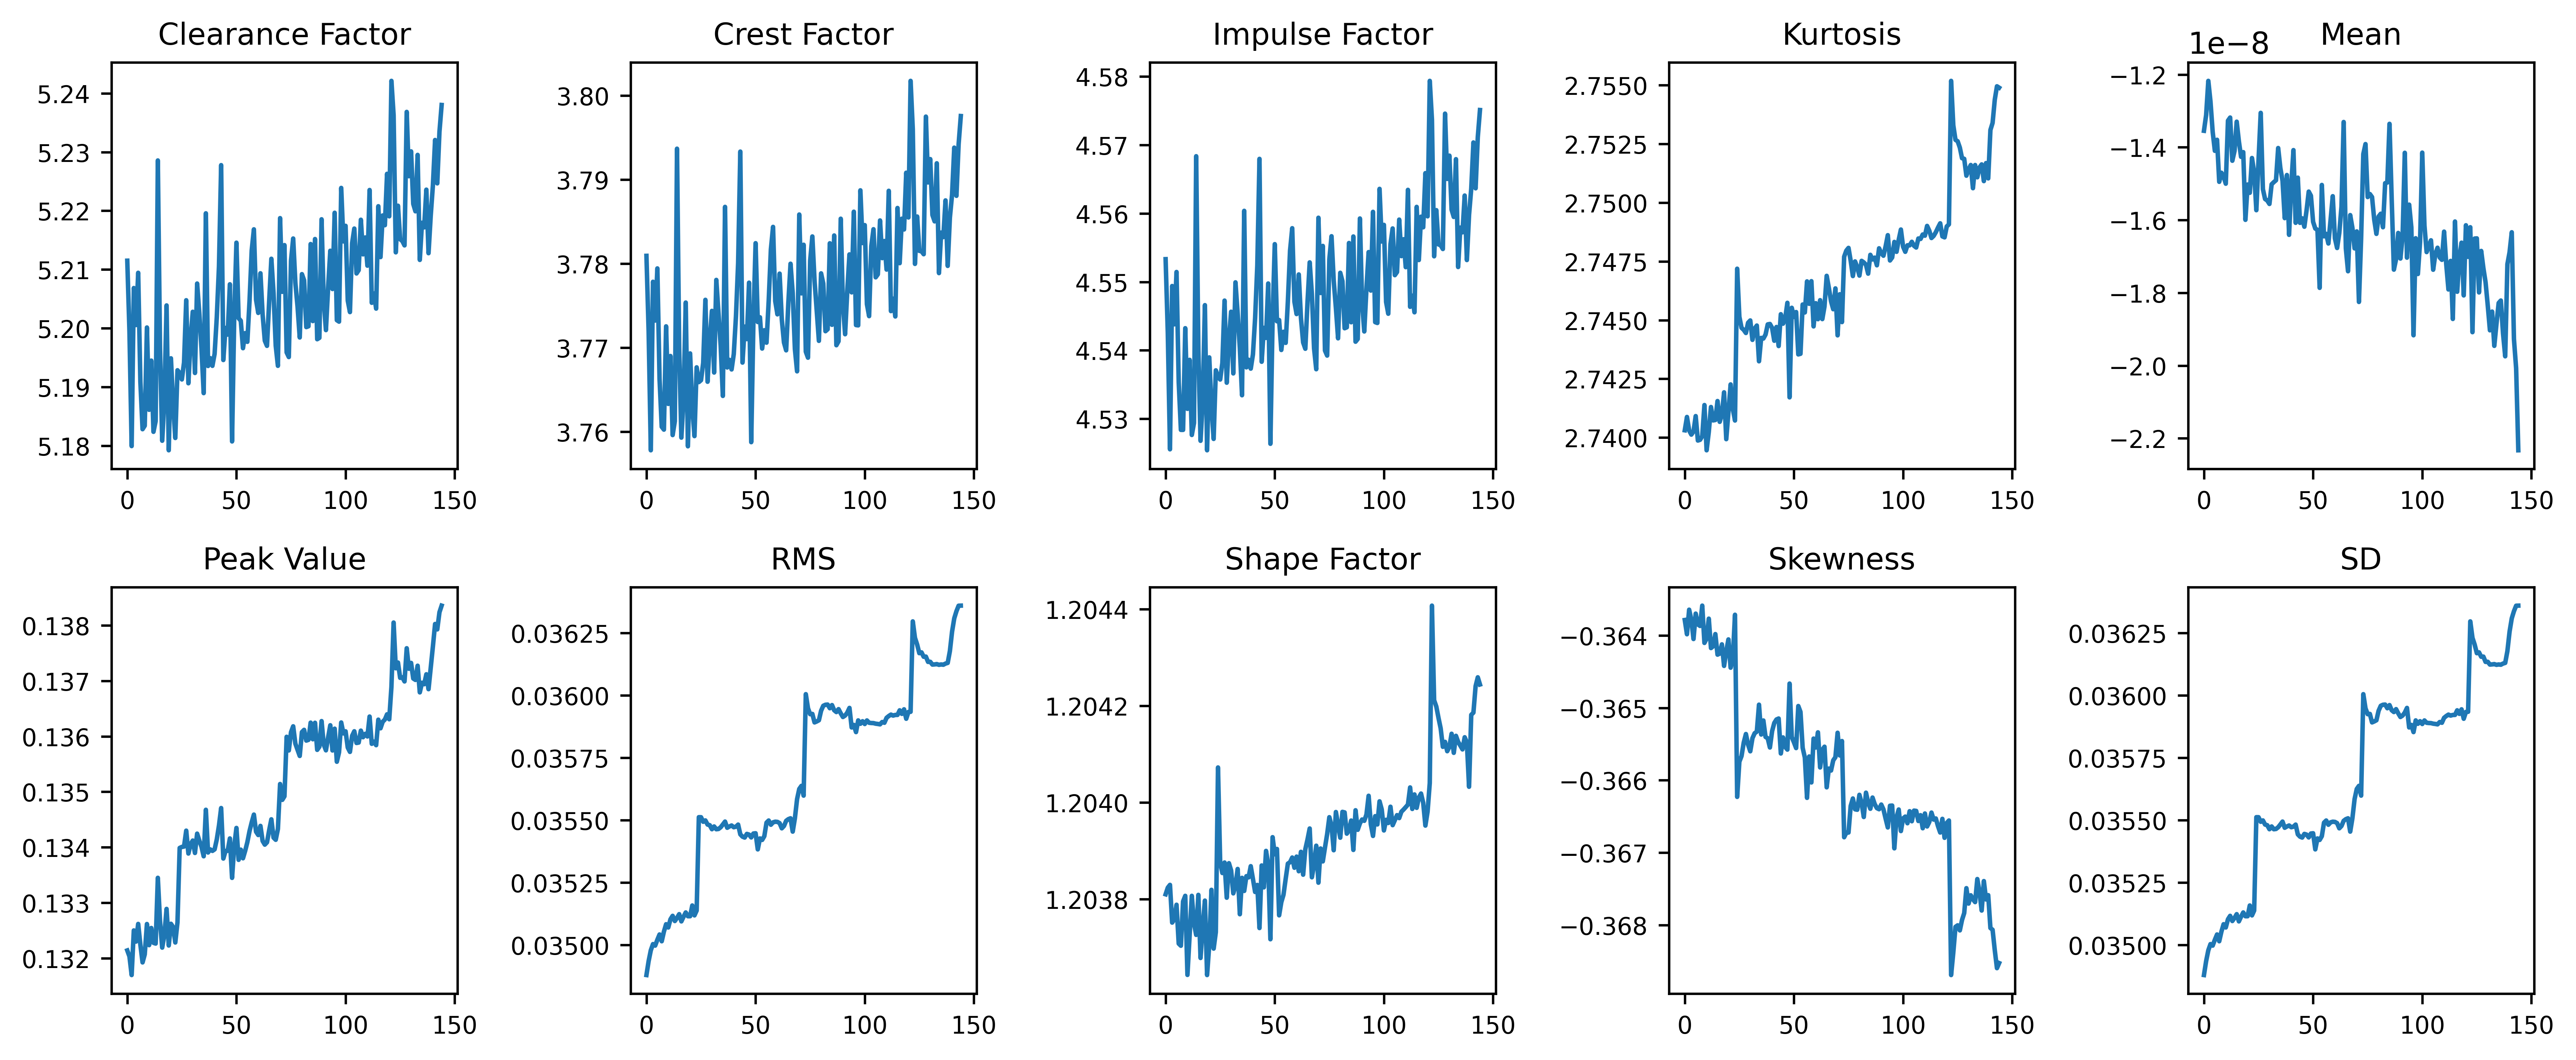

In [6]:
feature_names = ['Clearance Factor', 'Crest Factor', 'Impulse Factor', 'Kurtosis', 'Mean', 'Peak Value', 'RMS', 'Shape Factor', 'Skewness', 'SD']
feature_list = []
for i in tqdm(range(len(dc_v))):
    seg_list = []
    for j in range(5):
        v_t = dc_v[i][0*j:36000*(j+1), 0]
        ewt, mfb, boundaries = EWT1D(v_t, N=9)
        
        corr = np.array([np.corrcoef(ewt[:, mode], v_t)[0, 1] for mode in range(9)])
        f_mode = ewt[:, np.argmax(corr)]
        v_c = v_t-f_mode # fundamental mode filtering
        seg_list.append(feature_extraction(v_c))
    seg_list = np.vstack(seg_list)
    feature_list.append(np.mean(seg_list, axis=0))

feature_list = np.vstack(feature_list)
fig, ax = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax[i//5,i%5].plot(feature_list[:, i])
    ax[i//5,i%5].set_title(feature_names[i], fontsize=10)
    ax[i//5,i%5].tick_params(axis='x', labelsize=8)
    ax[i//5,i%5].tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()
plt.close()
